<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BME I5100 Biomed Sig Processing (2025)

Joel Deerwester

Reproduce figures - slides 8, 9, 11, 12

In [ ]:
import os
import math
import numpy as np
from scipy import io as sio
from scipy import signal, stats
from matplotlib import pyplot as plt

In [ ]:
# some helpers...

def save_fig(fig_name):
    # save figure in cwd
    filename = f"joel_deerwester_hw1-{fig_name}.png"
    if os.path.exists(filename):
        os.remove(filename)
    plt.savefig(filename)
    print(f"figure saved as {filename}")


def calculate_pdf(x, sigma):
    # manual implementation of s11 pdf eq
    # updated: switched to vector instead of element-wise operation
    term1 = 1 / (sigma * np.sqrt(2*np.pi))
    term2 = np.exp(-(x**2) / (2*sigma**2))
    p_x = term1 * term2

    return p_x


def hist_pdf(data, bins=50):
    # plot pdf using calculate_pdf()
    # updated: also switched pdf_values_raw assignment to vector oper
    n = len(data)
    mu, sigma = np.mean(data), np.std(data)
    xmin, xmax = data.min(), data.max()
    x_pdf = np.linspace(xmin, xmax, n)

    pdf_values_raw = calculate_pdf(x_pdf-mu, sigma)

    bin_width = (xmax-xmin)/bins
    pdf_values_scaled = pdf_values_raw * n * bin_width

    return x_pdf, pdf_values_scaled


def local_std(data, window=10):
    # normalize w local std est
    n = len(data)
    normalized_data = np.zeros(n, dtype=float)

    for i in range(window, n-1):
        start_idx = max(0, i-window)
        end_idx = min(n, i+window)
        local_window = data[start_idx:end_idx]
        s = np.std(local_window)
        normalized_data[i] = data[i]/s

    return normalized_data

In [ ]:
# loads datasets directly in session runtime
fns = {'FN1':'eeg.mat', 'FN2':'tonguemg.mat'}

fig1 = 'pl1_sl8' # plot 1, slide 8
fig2 = 'pl2_sl9'
fig3 = 'pl3_sl11'
fig4 = 'pl4_sl12'



# eeg dataset
if not os.path.exists('eeg.mat'):
    !wget https://parralab.org/teaching/biomed-dsp/eeg.mat
eeg_mat = sio.loadmat('eeg.mat')
eeg = eeg_mat['x'].T
del eeg_mat
os.remove('eeg.mat')


# tongue emg dataset
if not os.path.exists('tonguemg.mat'):
    !wget https://parralab.org/teaching/biomed-dsp/tonguemg.mat
tongue = sio.loadmat('tonguemg.mat')
tong_emg = tongue['tong_emg']
emg = stats.zscore(tong_emg)
emg_norm = local_std(emg)
del tongue
os.remove('tonguemg.mat')

--2025-10-06 16:49:03--  https://parralab.org/teaching/biomed-dsp/eeg.mat
Resolving parralab.org (parralab.org)... 94.26.67.49
Connecting to parralab.org (parralab.org)|94.26.67.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 321980 (314K)
Saving to: ‘eeg.mat’

eeg.mat             100%[===================>] 314.43K  1.16MB/s    in 0.3s    

2025-10-06 16:49:04 (1.16 MB/s) - ‘eeg.mat’ saved [321980/321980]

--2025-10-06 16:49:04--  https://parralab.org/teaching/biomed-dsp/tonguemg.mat
Resolving parralab.org (parralab.org)... 94.26.67.49
Connecting to parralab.org (parralab.org)|94.26.67.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23048 (23K)
Saving to: ‘tonguemg.mat’

tonguemg.mat        100%[===================>]  22.51K  --.-KB/s    in 0.06s   

2025-10-06 16:49:05 (347 KB/s) - ‘tonguemg.mat’ saved [23048/23048]



/tmp/ipython-input-2479898776.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  normalized_data[i] = data[i]/s


# First plots - slide 8

In [ ]:
eeg.shape

(2500, 128)

figure saved as joel_deerwester_hw1-pl1_sl8.png


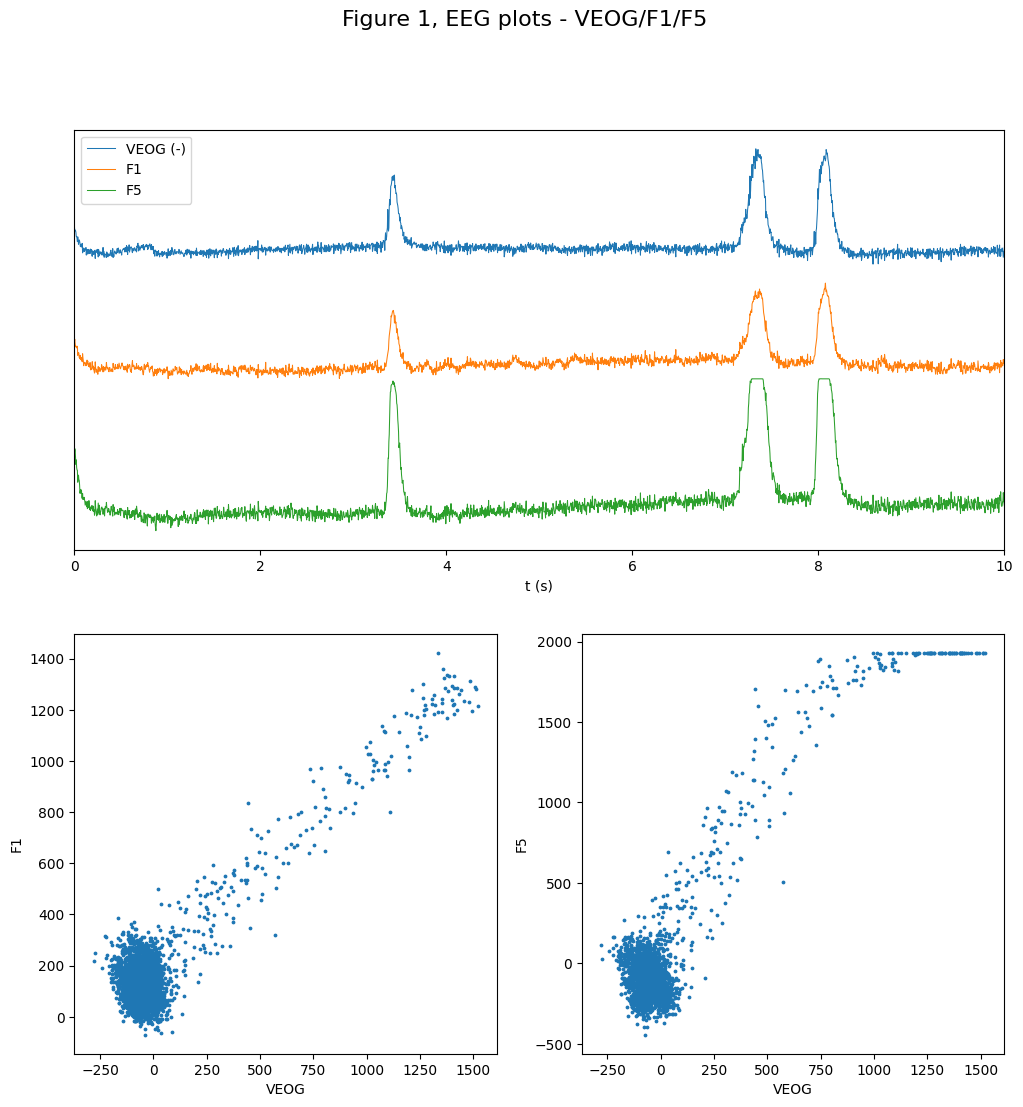

In [ ]:
fs = 250
n = eeg.shape[0]
# n samples, n/fs per second
x_ax = np.linspace(0, n/fs, n)

fig = plt.figure(figsize=(12, 12))
fig.suptitle('Figure 1, EEG plots - VEOG/F1/F5', fontsize=16)

ax1 = plt.subplot(2, 1, 1)  # by-channel time series
ax2 = plt.subplot(2, 2, 3)  # scatter, 0/7: F1
ax3 = plt.subplot(2, 2, 4)  # scatter, 0/1: F5

# ax1.plot(x_ax,-eeg[:, 0]
# ax1.plot(x_ax,eeg[:, [7, 1]]
ax1.plot(x_ax,-eeg[:, 0]+4e3, label='VEOG (-)', lw=0.75)
ax1.plot(x_ax,eeg[:, 7]+2e3, label='F1', lw=0.75)
ax1.plot(x_ax,eeg[:, 1], label='F5', lw=0.75)

ax1.set_xlabel('t (s)')
ax1.set_ylabel('uV')
ax1.get_yaxis().set_visible(False)
ax1.legend(loc='upper left')
ax1.set_xlim(0,10)

ax2.scatter(-eeg[:,0], eeg[:,7], s=3)
ax2.set_xlabel('VEOG')
ax2.set_ylabel('F1')

ax3.scatter(-eeg[:,0], eeg[:,1], s=3)
ax3.set_xlabel('VEOG')
ax3.set_ylabel('F5')


save_fig(fig1)
plt.show()

# Second plots - slide 9

figure saved as joel_deerwester_hw1-pl2_sl9.png


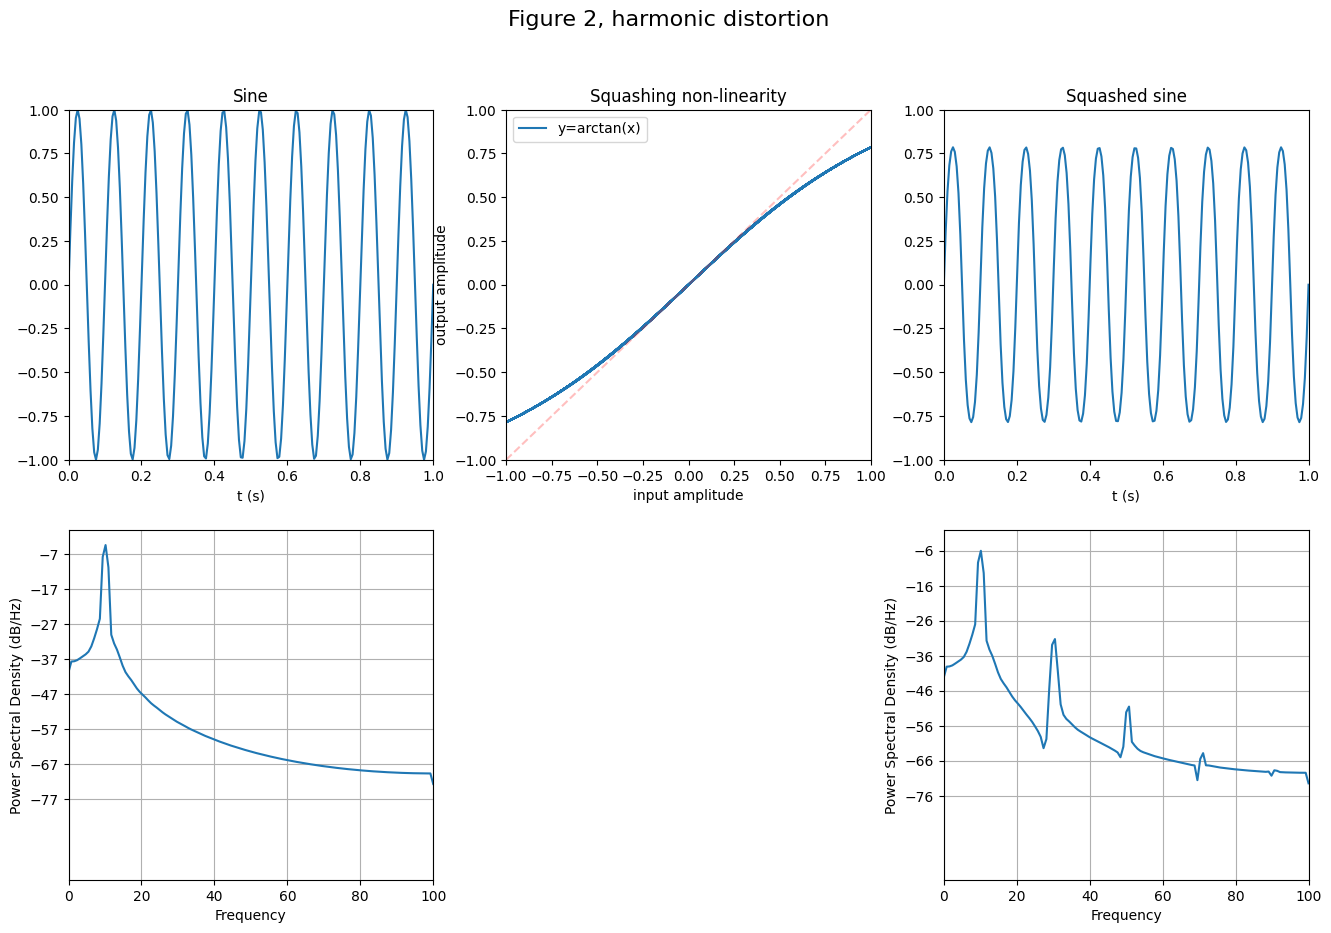

In [ ]:
f = 10
fs = 200

# generate signals
# print("plot 2... generating signals")
x = np.linspace(0, 1, fs)
y_orig = np.sin(2*np.pi*f*x)
y_atan = np.arctan(y_orig)


fig = plt.figure(figsize=(16, 10))
fig.suptitle('Figure 2, harmonic distortion', fontsize=16)
ax1 = plt.subplot(2, 3, 1)  # sine
ax2 = plt.subplot(2, 3, 2)  # compression ... sine/arctan
ax3 = plt.subplot(2, 3, 3)  # arctan
ax4 = plt.subplot(2, 3, 4)  # psd
ax5 = plt.subplot(2, 3, 6)  # psd, harmonic distortion


# plot 1 - sine wave and compression
ax1.plot(
    x, y_orig,
    label='sine y=sin(x)'
)
# ax1.plot(x, y_atan, label='squashed sine y=atan(sin(x))')
ax1.set_title('Sine')
ax1.set_xlabel('t (s)')
ax1.set_xlim(0, 1)
ax1.set_ylim(-1, 1)

# plot 2 - squashing non-linearity
ax2.plot(
    y_orig, y_atan,
    label='y=arctan(x)'
)
ax2.plot(
    [-1, 1],[-1, 1],
    'r--', alpha=0.25
)
ax2.set_title('Squashing non-linearity')
ax2.legend()
ax2.set_xlabel('input amplitude')
ax2.set_ylabel('output amplitude')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)

# plot 3 - sine wave and compression
# ax1.plot(x, y_orig, label='sine y=sin(x)')
ax3.plot(
    x, y_atan,
    label='squashed sine y=atan(sin(x))'

)
ax3.set_title('Squashed sine')
ax3.set_xlabel('t (s)')
ax3.set_xlim(0, 1)
ax3.set_ylim(-1, 1)

# plot 4/5 - psds

# f, Pxx_den = signal.welch(y_orig, fs, nperseg=1024)
# ax4.semilogy(f, Pxx_den)
# ax4.set_ylim([0.5e-15, 1])
# ax4.set_xlabel('frequency [Hz]')
# ax4.set_ylabel('PSD [V**2/Hz]')

ax4.psd(y_orig, Fs=fs, label='original spectrum')
ax4.set_ylim(-100, 0)
ax4.set_xlim(0, 100)

# f, Pxx_den = signal.welch(y_atan, fs, nperseg=1024)
# ax5.semilogy(f, Pxx_den)
# ax5.set_ylim([0.5e-15, 1])
# ax5.set_xlabel('frequency [Hz]')
# ax5.set_ylabel('PSD [V**2/Hz]')

ax5.psd(y_atan, Fs=fs, label='squashed spectrum')
ax5.set_ylim(-100, 0)
ax5.set_xlim(0, 100)


save_fig(fig2)
plt.show()

# Third plots - slide 11

figure saved as joel_deerwester_hw1-pl3_sl11.png


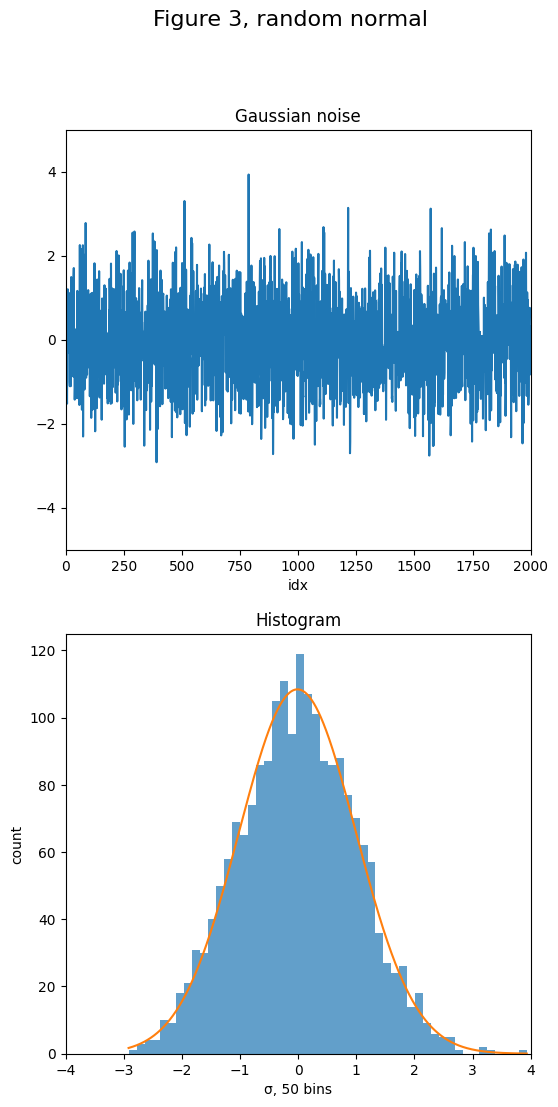

In [ ]:
x_2000 = np.random.normal(size=2000)
nbins=50  # for hist bins

fig = plt.figure(figsize=(6, 12))
fig.suptitle('Figure 3, random normal', fontsize=16)

ax1 = plt.subplot(2, 1, 1)  # random noise
ax2 = plt.subplot(2, 1, 2)  # noise hist


# plot 1
ax1.plot(x_2000)
ax1.set_title('Gaussian noise')
ax1.set_xlabel('idx')
ax1.set_xlim(0, 2000)
ax1.set_ylim(-5,5)

# plot 2 - pdf
ax2.hist(x_2000, bins=nbins, alpha=0.7)
x_pdf_theoretical, pdf_values_scaled_theoretical = hist_pdf(x_2000, nbins)
ax2.plot(x_pdf_theoretical, pdf_values_scaled_theoretical)

ax2.set_title('Histogram')
ax2.set_xlabel('σ, 50 bins')
ax2.set_ylabel('count')
ax2.set_xlim(-4, 4)


save_fig(fig3)
plt.show()

# Fourth plots - slide 12

figure saved as joel_deerwester_hw1-pl4_sl12.png


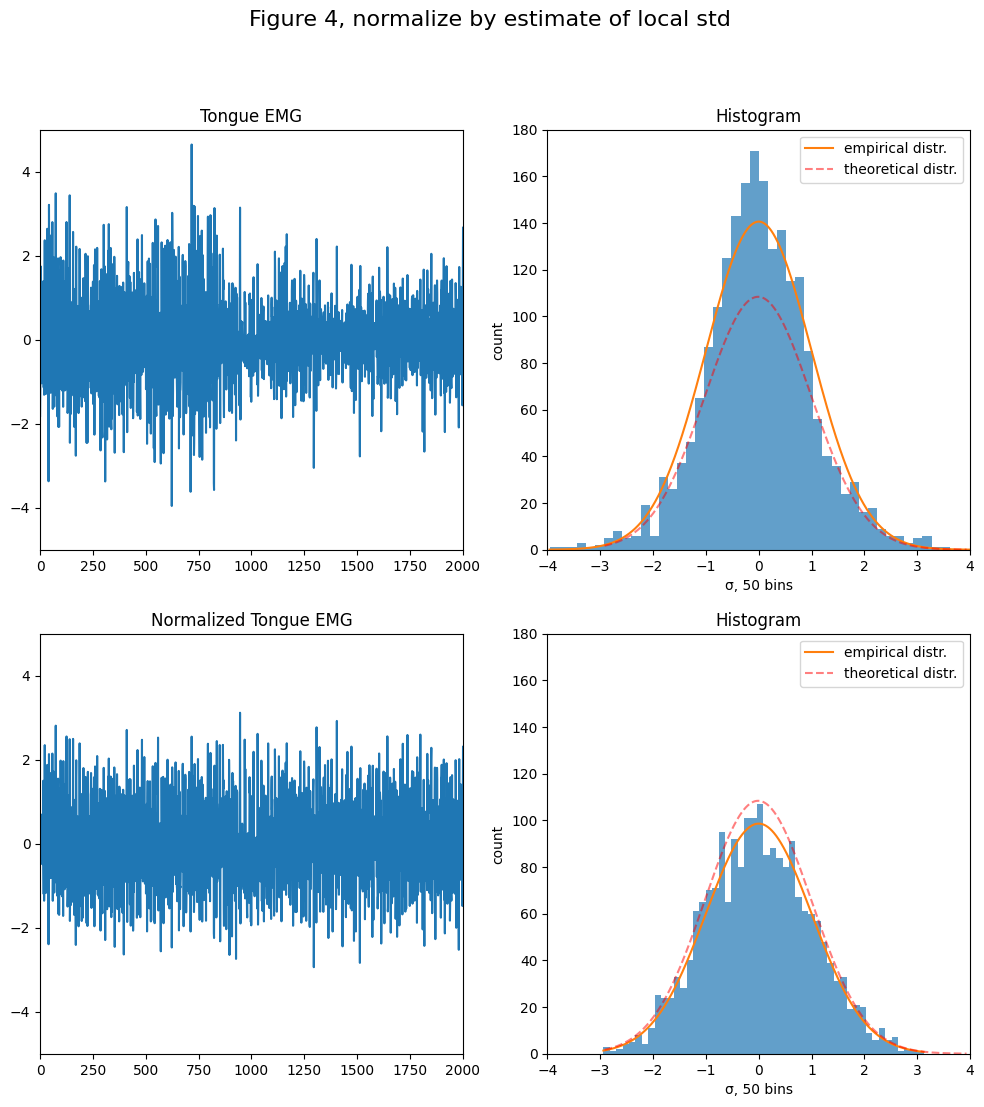

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('Figure 4, normalize by estimate of local std', fontsize=16)

ax1 = plt.subplot(2, 2, 1)  # emg
ax2 = plt.subplot(2, 2, 2)  # emg hist
ax3 = plt.subplot(2, 2, 3)  # normalized
ax4 = plt.subplot(2, 2, 4)  # normalized hist


# plot 1&2 - original
ax1.plot(emg)
ax1.set_title('Tongue EMG')
ax1.set_ylim(-5, 5)
ax1.set_xlim(0, 2000)

# x_pdf_theoretical, pdf_values_scaled_theoretical = hist_pdf(x_2000, nbins)

ax2.hist(emg, bins=nbins, alpha=0.7)
# included both theoretical and empirical (emg) pdf solutions
x_pdf, pdf_values_scaled = hist_pdf(emg, nbins)
ax2.plot(x_pdf, pdf_values_scaled, label='empirical distr.')
ax2.plot(
    x_pdf_theoretical, pdf_values_scaled_theoretical,
    'r--', alpha=0.5, label='theoretical distr.')
ax2.legend()

ax2.set_title('Histogram')
ax2.set_xlabel('\u03C3, 50 bins')
ax2.set_ylabel('count')

ax2.set_xlim(-4, 4)
ax2.set_ylim(0, 180)


# plot 3&4 - local std normalized
ax3.plot(emg_norm)
ax3.set_title('Normalized Tongue EMG')
ax3.set_ylim(-5, 5)
ax3.set_xlim(0, 2000)


ax4.hist(emg_norm, bins=nbins, alpha=0.7)
# included both theoretical and empirical (emg) pdf solutions
x_pdf, pdf_values_scaled = hist_pdf(emg_norm, nbins)
ax4.plot(x_pdf, pdf_values_scaled, label='empirical distr.')
ax4.plot(
    x_pdf_theoretical, pdf_values_scaled_theoretical,
    'r--', alpha=0.5, label='theoretical distr.'
)
ax4.legend()

ax4.set_title('Histogram')
ax4.set_xlabel('\u03C3, 50 bins')
ax4.set_ylabel('count')

ax4.set_xlim(-4, 4)
ax4.set_ylim(0, 180)




save_fig(fig4)
plt.show()